# OpenCV ML SVM for OCR

### Image Augmentation 
- Image augmentation is one useful technique that can **increase** the size of the **training set**, **without** acquiring **new images**.

In [3]:
def img_augmentation(img):
    kernel = np.ones((3,3),np.uint8)
    kernel2D = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    h, w = img.shape
    center = (w // 2, h // 2)
    M05a = cv2.getRotationMatrix2D(center, 5, 1.0)
    M05b = cv2.getRotationMatrix2D(center, -5, 1.0)
    Mr = np.float32([[1, 0, 2], [0, 1, 0]])
    Ml = np.float32([[1, 0, -2], [0, 1, 0]])
    Mr3 = np.float32([[1, 0, 3], [0, 1, 0]])
    Ml3 = np.float32([[1, 0, -3], [0, 1, 0]])
    
    img_blur = cv2.GaussianBlur(img,(3,3),0)
    img_closing = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    img_erode = cv2.erode(img, kernel)
    img_tr_r = cv2.warpAffine(img, Mr, (w, h), borderValue=(255,255,255))
    img_tr_l = cv2.warpAffine(img, Ml, (w, h), borderValue=(255,255,255))
    img_tr_r3 = cv2.warpAffine(img, Mr3, (w, h), borderValue=(255,255,255))
    img_tr_l3 = cv2.warpAffine(img, Ml3, (w, h), borderValue=(255,255,255))
    img_rot5a = cv2.warpAffine(img, M05a, (w, h), borderValue=(255,255,255))
    img_rot5b = cv2.warpAffine(img, M05b, (w, h), borderValue=(255,255,255))
    
    return[img, img_blur, img_closing, img_erode, img_rot5a, img_rot5b, img_tr_r, img_tr_l, img_tr_r3, img_tr_l3]

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread("char_dataset/0/0_0.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [16]:
imgs = img_augmentation(gray)

In [17]:
cv2.imshow('app', imgs[8])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
len(imgs)

10

In [19]:
for i, img in enumerate(imgs):
    cv2.imshow("char augmented - %d" % i, img)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Deskewing & HOG

- HOG :
    - **Feature Descriptor** is a representation of an image or an image patch that simplifies the image by extracting **useful information**.
    - Typically, a feature descriptor converts an image of size width x height x 3 (channels ) to a **feature vector** / **array** of length `n`.
    - Where `n` could be **width x height x channel** on original image.
    - The **feature vector** produced by **HOG algorithms** when fed into an image classification algorithms like Support Vector Machine (SVM) **produce good results**.
- HOG Algorithm :
     - Calculate the Gradient Images :
         - Sobel Operator (`cv2.Sobel()`): Using the sobel operation, you can detect the edges of an image in both horizontal and vertical directions 
     - Find the magnitude ($g$) and direction ($\theta$) of gradient :
         - Using `cv2.cartToPolar(x,y)` : transform cartesian to polar image.

In [20]:
SZ=20
bin_n = 16

affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img


def hog(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)

    # quantizing binvalues in (0...16)
    bins = np.int32(bin_n*ang/(2*np.pi))   
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)   
    return hist

- Deskewing (deskew the image using its second order moments)

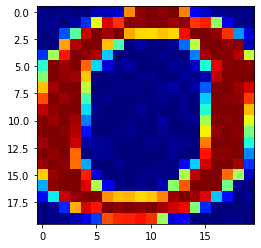

In [21]:
img = cv2.imread("char_dataset/0/0_8.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.bitwise_not(gray)

h, w= gray.shape
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, -10, 1.0)
gray_rot = cv2.warpAffine(gray, M, (w, h), borderValue=(180,180,180))

plt.imshow(gray, cmap="jet")

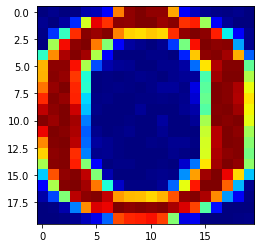

In [22]:
deskew_img = deskew(gray)

plt.imshow(deskew_img, cmap="jet")

- HOG

In [23]:
hog_img = hog(deskew_img)

In [24]:
hog_img.shape

(64,)

- Load Dataset

In [25]:
dataset = "char_dataset"

label = []
for folder in os.listdir(dataset):
    label.append(folder)
print("Label" , label)
print("Number of Class ", len(label))

Label ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z']
Number of Class  33


In [26]:
image_vec = []
target_data = []
for folder in os.listdir(dataset):
    for filename in os.listdir(dataset + "/" + folder)[:10]:
        if filename.find('.jpg') < 0 :
            continue
        img = cv2.imread(dataset + "/" + folder + "/" + filename, 0)
        for img in img_augmentation(img):
            img_hog = hog(deskew(img))
            image_vec.append(img_hog)
            idx = label.index(folder)
            target_data.append(idx)

In [27]:
len(image_vec)

3290

- convert data to numpy array

In [28]:
image_vec[0].shape

(64,)

In [29]:
image_vec[0].reshape(-1,64)

array([[2532.77897644,  744.54157639, 1225.7422924 , 1477.24721527,
         928.63112831,   27.45906067,  176.26589775, 1375.43791199,
        1083.20094681,  831.21136475, 1127.39434814,  912.72621155,
         597.04534626,   93.60606003,  100.45275879, 2859.96232224,
         490.20800114,   58.26263666,   33.83262062,    0.        ,
        1382.64660621, 1647.45049858,  936.05144501, 1784.80707169,
        1460.21941376,    0.        ,    0.        ,    0.        ,
        1467.83242774, 1662.75390625,  427.34214783, 4998.39179516,
        1259.57373047,   38.31312227,    0.        ,  395.72781563,
        2237.1969862 ,  902.21229744,  794.69460773, 4028.88585758,
        1247.97481537,   17.49285507,   10.2956295 ,    0.        ,
        1200.51200461, 1496.30647278,  822.62758064, 1021.60772753,
        1440.69601202,  435.07816982, 1933.03537464, 1113.32161331,
         915.99999809,    0.        ,   14.76482391, 4491.79279709,
         980.46136951,  831.78700256, 1361.09838

In [30]:
x = np.float32(image_vec).reshape(-1,64)
y = np.array(target_data)

x.shape, y.shape

((3290, 64), (3290,))

- Split Dataset

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1645, 64), (1645, 64), (1645,), (1645,))

- Train Model

In [32]:
# setup SVM model
svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setType(cv2.ml.SVM_C_SVC)
svm.setC(2.67)
svm.setGamma(5.383)

In [33]:
# do train
svm.train(x_train, cv2.ml.ROW_SAMPLE, y_train)

True

- Save model

In [34]:
svm.save('svm_data.dat')

- Apply Prediction for test dataset

In [35]:
y_predict = svm.predict(x_test)[1]

- Evaluate Test Result

In [36]:
mask = y_predict.T[0]==y_test
correct = np.count_nonzero(mask)
accuracy = correct*100.0/y_predict.size
print("accuracy : %.2f" % accuracy)

accuracy : 98.78


- Evaluate using **Scikit-Learn**

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predict, target_names=label))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        48
           1       1.00      0.96      0.98        52
           2       1.00      0.98      0.99        58
           3       1.00      1.00      1.00        47
           4       0.93      0.98      0.96        55
           5       1.00      1.00      1.00        55
           6       0.98      1.00      0.99        49
           7       1.00      1.00      1.00        45
           8       1.00      0.98      0.99        52
           9       1.00      1.00      1.00        44
           A       0.98      0.95      0.96        57
           B       0.96      1.00      0.98        45
           C       1.00      0.96      0.98        52
           D       0.91      0.98      0.94        50
           E       1.00      1.00      1.00        57
           F       1.00      1.00      1.00        51
           G       1.00      1.00      1.00        50
           H       1.00    

___

## Compare Train Result SVM Model Using Scikit-Learn

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [39]:
svc_cross = SVC(kernel='linear', C=10)

scores = cross_val_score(svc_cross, x_train, y_train, cv=4)
scores

array([0.97572816, 0.98296837, 0.96593674, 0.96350365])

In [40]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.97 accuracy with a standard deviation of 0.01


In [41]:
param_grid = {'C': [2.67],
              'gamma': [5.383], }
clf = GridSearchCV(SVC(kernel='linear', class_weight='balanced'), param_grid)
clf = clf.fit(x_train, y_train)

In [42]:
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred, target_names=label))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93        48
           1       1.00      0.96      0.98        52
           2       1.00      0.98      0.99        58
           3       1.00      1.00      1.00        47
           4       0.93      0.98      0.96        55
           5       1.00      1.00      1.00        55
           6       0.98      1.00      0.99        49
           7       1.00      1.00      1.00        45
           8       1.00      0.98      0.99        52
           9       1.00      1.00      1.00        44
           A       0.98      0.95      0.96        57
           B       0.96      1.00      0.98        45
           C       1.00      0.96      0.98        52
           D       0.92      0.98      0.95        50
           E       1.00      1.00      1.00        57
           F       1.00      1.00      1.00        51
           G       1.00      1.00      1.00        50
           H       1.00    

___

# Apply Model to Plate Number

In [43]:
def drawPred(frame, label, left, top, right, bottom):
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 0, 255), 2)

    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), 
                         (max(right, left + labelSize[0]), top + baseLine), (255, 0, 255), -1)
    
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.50, (255, 255, 255), 1)
    return frame

In [44]:
def preprocessing(img, h1, h2):
    # get roi & resize 
    h, w, c = img.shape
    y1, y2, x1, x2 = int(h1), int(h2), int(w*0.30), int(w*0.70)
    roi = img[y1:y2, x1:x2]
    scale = 300/roi.shape[0]
    roi = cv2.resize(roi, (0,0), fx=scale, fy=scale)
    
    #convert to gray -> binary
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    __, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh, roi, [x1, y1, x2, y2], scale
    
def get_contours(thresh):
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    h, w, c = img.shape
    size = h*w
    contours = [cc for i, cc in enumerate(contours) if contour_char_OK(cc, size)]
    return contours

def contour_char_OK(cc, size=1000000):
    x, y, w, h = cv2.boundingRect(cc)
    area = cv2.contourArea(cc)
    
    if w < 3 or h < 5 or area < 120: 
        return False
    
    validDimentson = w/h > 0.11 and w/h < 0.78
    varidAreaRatio = area/(w*h)  > 0.17
    return validDimentson and varidAreaRatio

def sort_contours(contours, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(cnt) for cnt in contours]
    
    cnts, boundingBoxes = zip(*sorted(zip(contours, boundingBoxes), key=lambda b:b[1][i], reverse=reverse))
    return cnts, boundingBoxes

In [45]:
def crop_plate(thresh, contours):
    rects = []
    for i, cnt in enumerate(contours) :
        rect = cv2.boundingRect(cnt)
        rects.append(rect)

    rects = np.array(rects)

    if len(rects) < 4 :
        return False, thresh, []
    rects = similar_rect(rects, row=3, n=2) #similar rect for closest `h` (row 3)

    if len(rects) < 4 :
        return False, thresh, []
    rects = similar_rect(rects, row=2, n=2) #similar rect for closest `w` (row 2)

    if len(rects) < 4 :
        return False, thresh, []
    x1 = rects[:, 0].min()
    x2 = rects[:, 0].max() + rects[:, 2].max()
    y1 = rects[:, 1].min()
    y2 = rects[:, 1].max() + rects[:, 3].max()
    plate_number = thresh[y1:y2, x1:x2]
    return True, plate_number, [x1, y1, x2, y2]

def similar_rect(rects, row=3, n=2):
    mean = np.mean(rects[:, row])
    std = np.std(rects[:, row])
    rects = np.array([rect for rect in rects if abs(rect[row] - mean) < n*std and rect_ok(rect)])
    return rects

def rect_ok(rect):
    x, y, w, h = rect
    return w/h > 0.11 and w/h < 0.7

In [60]:
img = cv2.imread(r"dataset\DD1315LN.jpg")

h, w, c = img.shape
thresh, roi, roi_rect, s = preprocessing(img, h1=0.5*h, h2=0.85*h )

cv2.imshow("car img", thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [61]:
# img = cv2.imread(r"dataset\AB1196VK.jpg")
img = cv2.imread(r"dataset\DD1315LN.jpg")


h, w, c = img.shape
thresh, roi, roi_rect, s = preprocessing(img, h1=0.5*h, h2=0.85*h )

contours = get_contours(thresh)

is_plate, plate_img, plate_rect = crop_plate(thresh, contours)

# pts = find_4_coord(contours)
# plate_img = transform(plate_img, pts)

chars = []
if is_plate :
    x1, y1, x2, y2 = plate_rect
    x1_, y1_, x2_, y2_ = roi_rect
    left = int(x1/s) + x1_
    top = int(y1/s) + y1_
    right = int(x2/s) + x1_
    bottom = int(y2/s) + y1_
    plate_img_rgb = roi[y1:y2, x1:x2] # get image license plate
    
    contours = get_contours(plate_img)
    if len(contours) > 1:
        contours, __ = sort_contours(contours) 
        for i, cnt in enumerate(contours) :
            x, y, w, h = cv2.boundingRect(cnt) # get bounding box each character
            
            char = plate_img_rgb[y:y+h, x:x+w]
            char_grey = cv2.cvtColor(char, cv2.COLOR_BGR2GRAY)
            char_inv = cv2.bitwise_not(char_grey)
            cv2.imshow("char_inv - %d" % i, char_inv)
            char_inv = cv2.resize(char_inv, (20,20))

            char_hog = hog(deskew(char_inv))
            chars.append(char_hog)
            
        chars = np.float32(chars).reshape(-1, 64)
        result = svm.predict(chars)[1].T[0]
        # print("result", result)
        text_result = [label[int(idx)] for idx in result]
        print("text_result", text_result)
        img = drawPred(img, ''.join(text_result), left, top - 5, right, bottom)

cv2.imshow("plate img", plate_img_rgb)
# cv2.imshow("car img", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

text_result ['D', 'D', '1', '1', '3', '1', '5', '6', 'L', 'N']


- Geometric Correction

In [ ]:
def find_4_coord(contours):
    perimeter = []
    for cc in contours:
        perimeter = cv2.approxPolyDP(cc, 0.09 * cv2.arcLength(cc, True), True)
    return np.array(perimeter[:,0,:])
        
def order_points(pts):

    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def transform(img, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    print(tl, tr, br, bl)

    for pt in rect.astype(np.uint16):
        cv2.circle(img, (pt[0], pt[1]), 4, (0,255,255), -1)

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth, 0],
        [maxWidth, maxHeight],
        [0, maxHeight]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (100, 150))
    return warped

In [37]:
ml_acc = [90, 50, 98, 100, 98, 100, 99, 95, 99, 0, 100, 98, 98, 99, 95, 90, 98, 96, 98, 0]
ml_err = [12.5, 62.5, 12.5, 0, 25, 37.5, 0, 100, 100, 75, 0, 25, 62.5, 12.5, 25, 33.3333, 0, 50 ,0, 0]
ml_acc.sort(reverse=False)
ml_err.sort(reverse=True)

py_acc = [90, 30, 90, 100, 95, 96, 100, 0, 0, 20, 100, 95, 96, 96, 95, 90, 90, 94, 100, 100]
py_err = [12.5, 62.5, 12.5, 0, 37.5, 0, 12.5, 12.5, 14.2857, 100, 0, 25, 37.5, 12.5, 25, 33.3333, 12.5 ,50, 12.5, 87.5]
py_acc.sort(reverse=False)
py_err.sort(reverse=True)

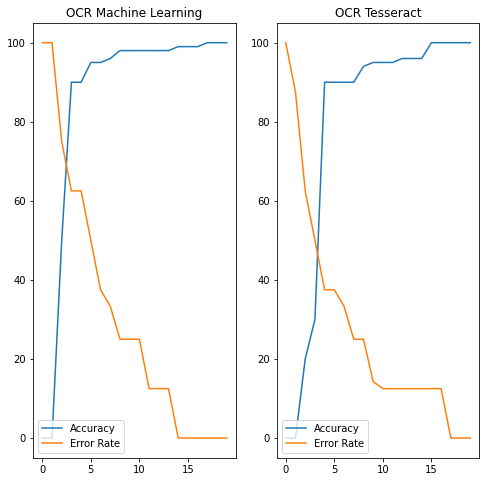

In [40]:
import matplotlib.pyplot as plt

ranges = range(0,20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(ranges, ml_acc, label='Accuracy')
plt.plot(ranges, ml_err, label='Error Rate')
plt.legend(loc='lower left')
plt.title('OCR Machine Learning')

plt.subplot(1, 2, 2)
plt.plot(ranges, py_acc, label='Accuracy')
plt.plot(ranges, py_err, label='Error Rate')
plt.legend(loc='lower left')
plt.title('OCR Tesseract')
plt.show()